In [1]:
%pip install scikit-learn pandas numpy matplotlib seaborn scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [271]:

import pandas as pd
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import OneHotEncoder

In [272]:
tps = {
    'X': np.int64,
    'income': np.float64,
    'name_email_similarity': np.float64,
    'prev_address_months_count': np.float64,
    'current_address_months_count': np.float64,
    'customer_age': np.float64,
    'days_since_request': np.float64,
    'intended_balcon_amount': np.float64,
    'payment_type': object,
    'zip_count_4w': np.float64,
    'velocity_6h': np.float64,
    'velocity_24h': np.float64,
    'velocity_4w': np.float64,
    'bank_branch_count_8w': np.float64,
    'date_of_birth_distinct_emails_4w': np.float64,
    'employment_status': object,
    'credit_risk_score': np.float64,
    'email_is_free': np.float64, # binary
    'housing_status': object,
    'phone_home_valid': np.float64, # binary
    'phone_mobile_valid': np.float64, # binary
    'bank_months_count': np.float64,
    'has_other_cards': np.float64, # binary
    'proposed_credit_limit': np.float64,
    'foreign_request': np.float64, # binary
    'source': object,
    'session_length_in_minutes': np.float64,
    'device_os': object,
    'keep_alive_session': np.float64, # binary
    'device_distinct_emails_8w': np.float64,
    'device_fraud_count': np.float64,
    'month': np.float64,
    'credit_utilization_ratio': np.float64,
    'distance_to_nearest_bank_branch': np.float64,
    'recent_loan_approval_ratio': np.float64,
    'transaction_amount_ratio': np.float64,
    'fraud_bool': np.float64 # binary
}

def load_train_csv(file):
    return pd.read_csv(file, names=tps.keys(),dtype=tps, skiprows=1)
def load_test_csv(file):
    a = tps.copy()
    a.pop('fraud_bool')
    print(a)
    return pd.read_csv(file, names=a.keys(),dtype=a, skiprows=1)

In [273]:
df = load_train_csv('train.csv')
df_test = load_test_csv('test.csv')
test_index1 = df_test['X']
print('Dataframe shape: ', df.shape)

{'X': <class 'numpy.int64'>, 'income': <class 'numpy.float64'>, 'name_email_similarity': <class 'numpy.float64'>, 'prev_address_months_count': <class 'numpy.float64'>, 'current_address_months_count': <class 'numpy.float64'>, 'customer_age': <class 'numpy.float64'>, 'days_since_request': <class 'numpy.float64'>, 'intended_balcon_amount': <class 'numpy.float64'>, 'payment_type': <class 'object'>, 'zip_count_4w': <class 'numpy.float64'>, 'velocity_6h': <class 'numpy.float64'>, 'velocity_24h': <class 'numpy.float64'>, 'velocity_4w': <class 'numpy.float64'>, 'bank_branch_count_8w': <class 'numpy.float64'>, 'date_of_birth_distinct_emails_4w': <class 'numpy.float64'>, 'employment_status': <class 'object'>, 'credit_risk_score': <class 'numpy.float64'>, 'email_is_free': <class 'numpy.float64'>, 'housing_status': <class 'object'>, 'phone_home_valid': <class 'numpy.float64'>, 'phone_mobile_valid': <class 'numpy.float64'>, 'bank_months_count': <class 'numpy.float64'>, 'has_other_cards': <class 'nu

In [274]:


def check_path(path, name, ext):
    i = 1
    while os.path.exists(f'{path}/{name}{i}.{ext}'):
        i+= 1
    return f'{path}/{name}{i}.{ext}'
def save(name, probabilities_test):
    out_name = check_path('.', name, 'csv')
    print(f'[{str(datetime.datetime.now())}] Saving at {out_name}')
    pd.DataFrame({'ID': test_index1, 'fraud_bool': probabilities_test}).to_csv(out_name, index=False)

In [275]:
df.describe()

,X,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,credit_utilization_ratio,distance_to_nearest_bank_branch,recent_loan_approval_ratio,transaction_amount_ratio,fraud_bool
count,70000.000000,69928.000000,69926.000000,70000.000000,70000.000000,69937.000000,7.000000e+04,70000.000000,70000.000000,70000.000000,...,70000.000000,70000.000000,70000.000000,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,69928.000000,70000.000000
mean,89581.905243,0.624884,0.476096,20.172314,74.987100,33.857372,9.074051e-01,5.451713,1056.634600,3785.552002,...,6.793101,0.617171,1.016314,0.0,6.621471,0.375151,0.499382,0.499663,0.625000,0.187986
std,159993.752643,0.278628,0.278483,46.544609,80.415403,11.784089,5.387399e+00,17.025634,729.621211,2165.047556,...,7.867693,0.486080,0.160062,0.0,1.322167,0.278650,0.288385,0.099500,0.282998,0.390704
min,1.000000,0.100000,0.000038,-1.000000,-1.000000,-69.103464,8.072689e-07,-9.353172,1.000000,-56.791556,...,-1.000000,0.000000,-1.000000,0.0,0.000000,0.100000,0.000020,0.045569,-0.085397,0.000000
25%,24870.750000,0.400000,0.230562,-1.000000,12.000000,30.000000,6.815046e-03,-1.197633,593.000000,2326.048728,...,2.346248,0.000000,1.000000,0.0,7.000000,0.100000,0.249992,0.432539,0.411665,0.000000
50%,49906.500000,0.700000,0.478173,-1.000000,43.000000,30.000000,1.423249e-02,-0.883100,882.000000,3551.948697,...,4.388250,1.000000,1.000000,0.0,7.000000,0.300000,0.497963,0.499608,0.713954,0.000000
75%,75114.500000,0.900000,0.705948,27.000000,116.000000,40.000000,2.437791e-02,-0.472679,1276.000000,4738.939244,...,8.115762,1.000000,1.000000,0.0,7.000000,0.600000,0.748532,0.566738,0.861991,0.000000
max,873760.000000,0.900000,0.999996,377.000000,399.000000,134.890683,7.845690e+01,112.756111,6368.000000,16356.364000,...,83.376775,1.000000,2.000000,0.0,7.000000,0.900000,0.999994,0.915793,1.086681,1.000000


In [276]:
df.head()

,X,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,credit_utilization_ratio,distance_to_nearest_bank_branch,recent_loan_approval_ratio,transaction_amount_ratio,fraud_bool
0,46366,0.5,0.373871,-1.0,121.0,30.0,0.003567,-0.472057,AC,658.0,...,other,1.0,1.0,0.0,7.0,0.5,0.764169,0.339598,0.543121,0.0
1,621359,0.9,0.825883,-1.0,49.0,50.0,0.030717,-1.061802,AB,640.0,...,windows,0.0,1.0,0.0,0.0,0.1,0.616470,0.498923,0.869324,1.0
2,43514,0.9,0.513736,55.0,5.0,50.0,0.027741,-0.544109,AB,1862.0,...,windows,1.0,1.0,0.0,7.0,0.1,0.302784,0.395494,0.891434,0.0
3,60994,0.9,0.489962,118.0,1.0,50.0,0.006615,-0.755948,AD,251.0,...,other,1.0,1.0,0.0,7.0,0.1,0.640823,0.488663,0.840134,0.0
4,66978,0.4,0.765966,-1.0,44.0,40.0,0.003371,-0.923310,AD,642.0,...,linux,1.0,1.0,0.0,7.0,0.6,0.373017,0.422912,0.340242,0.0


In [277]:
df_test.head()

,X,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,credit_utilization_ratio,distance_to_nearest_bank_branch,recent_loan_approval_ratio,transaction_amount_ratio
0,65525,0.9,0.630901,-1.0,142.0,30.0,0.010767,-0.703395,AB,719.0,...,8.261404,linux,0.0,1.0,0.0,7.0,0.1,0.027172,0.440292,0.892193
1,26893,0.9,0.639677,-1.0,0.0,30.0,0.024883,-1.543198,AB,1693.0,...,4.386385,other,1.0,1.0,0.0,7.0,0.1,0.449730,0.532189,0.923398
2,21998,0.1,0.540175,-1.0,101.0,30.0,0.001654,-1.417109,AB,492.0,...,14.451207,other,0.0,1.0,0.0,7.0,0.9,0.689448,0.519379,0.089402
3,67350,0.7,0.194405,-1.0,57.0,40.0,0.023723,8.820379,AA,1057.0,...,1.680632,linux,1.0,1.0,0.0,7.0,0.3,0.011866,0.555661,0.752496
4,57310,0.4,0.290227,-1.0,156.0,30.0,12.299196,21.733855,AA,476.0,...,9.397364,other,0.0,1.0,0.0,7.0,0.6,0.844082,0.473053,0.393684


In [278]:
df.isnull().sum()

X                                    0
income                              72
name_email_similarity               74
prev_address_months_count            0
current_address_months_count         0
customer_age                        63
days_since_request                   0
intended_balcon_amount               0
payment_type                        60
zip_count_4w                         0
velocity_6h                          0
velocity_24h                         0
velocity_4w                          0
bank_branch_count_8w                 0
date_of_birth_distinct_emails_4w     0
employment_status                   70
credit_risk_score                    0
email_is_free                        0
housing_status                       0
phone_home_valid                     0
phone_mobile_valid                  78
bank_months_count                    0
has_other_cards                      0
proposed_credit_limit                0
foreign_request                      0
source                   

In [279]:
print('No Frauds', round(df['fraud_bool'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['fraud_bool'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('ratio of frauds to non frauds', round(df['fraud_bool'].value_counts()[0]/df['fraud_bool'].value_counts()[1],2))

No Frauds 81.2 % of the dataset
Frauds 18.8 % of the dataset
ratio of frauds to non frauds 4.32


In [280]:
def unique_values(df):
    return [(i, df[i].unique()) for i in df.columns]

for i,j in unique_values(df):
    print(i, j)

X [ 46366 621359  43514 ...  28475  11482 513057]
income [0.5 0.9 0.4 0.2 0.7 0.3 0.1 0.6 0.8 nan]
name_email_similarity [0.37387107 0.82588341 0.51373642 ... 0.89127634 0.69402929 0.18265925]
prev_address_months_count [ -1.  55. 118. 147. 144.  52. 106.  45. 293.  25.  24.  29.  22.  12.
  96.  34.  67.  50. 100.  61.  36. 181.  28.  32.  35. 108.  93. 315.
 149.  65. 110. 127.  89.  49. 103.  10. 148.  99.  54.  11.  69.  31.
  62.  86. 101.  42.   9. 197. 195.  30.  51.  90.  27.  33.  94. 107.
  60.  91.  57.  83.  88.  37.  13.  59.  18.  21.  48.  47. 318.  26.
 292.  97.  95.  19. 323.  66. 328.  64.  46. 105.  53.   8.  38. 320.
 111. 230. 338.  23. 155. 204. 146.  92.  63. 122. 185.  78.  98. 141.
 177.  58.  80. 245. 214. 166. 112. 104.  56. 337.  82.  40. 180.  43.
 176.  87.  44. 109. 306.  85. 179. 170. 120. 102. 298. 156.  41. 125.
 174.  20.  68.  71. 311.  79.  74. 113. 163. 150. 217. 133. 139. 165.
 114. 319. 117.  76. 182. 287.  72. 132. 307. 302. 143. 212.  81. 299.


In [281]:
def clean_customer_age(age):
    min_age = 1
    max_age = 110
    if min_age <= age <= max_age:
        return round(age)
    else:
        return np.nan
df['customer_age'] = df['customer_age'].apply(clean_customer_age)
df_test['customer_age'] = df_test['customer_age'].apply(clean_customer_age)
print("customer_age", df['customer_age'].unique())

customer_age [ 30.  50.  40.  20.  10.  60.  70.  26.  80. 107.  27.  nan   3.  94.
 105.  75.  90.  44.  93.   8.  88.  37.  34.  33. 110.  84.  62.  98.
  99. 109.  43.  76.  54.  92.  36.  73.  23.  61.  25.  17.  31. 106.
  77. 104.]


In [282]:
df['prev_address_months_count'] = df['prev_address_months_count'].replace(-1, np.nan)
df['current_address_months_count'] = df['current_address_months_count'].replace(-1, np.nan)
df['bank_months_count'] = df['bank_months_count'].replace(-1, np.nan)
df['session_length_in_minutes'] = df['session_length_in_minutes'].replace(-1, np.nan)
df['device_distinct_emails_8w'] = df['device_distinct_emails_8w'].replace(-1, np.nan)

df_test['prev_address_months_count'] = df_test['prev_address_months_count'].replace(-1, np.nan)
df_test['current_address_months_count'] = df_test['current_address_months_count'].replace(-1, np.nan)
df_test['bank_months_count'] = df_test['bank_months_count'].replace(-1, np.nan)
df_test['session_length_in_minutes'] = df_test['session_length_in_minutes'].replace(-1, np.nan)
df_test['device_distinct_emails_8w'] = df_test['device_distinct_emails_8w'].replace(-1, np.nan)


In [283]:
X_train = df.drop(labels='fraud_bool', axis=1)
y_train = df.fraud_bool
X_test = df_test.copy()

In [284]:
def oneHotEncoder(df, df_test, columns):
    encoder = OneHotEncoder(sparse_output=False, min_frequency=1)
    # Transform the train data
    df_encoded = pd.DataFrame(encoder.fit_transform(df[columns]), columns=encoder.get_feature_names_out(columns))
    df = pd.concat([df, df_encoded], axis=1)
    df.drop(columns=columns, inplace=True)

    # Transform the test data
    df_test_encoded = pd.DataFrame(encoder.transform(df_test[columns]), columns=encoder.get_feature_names_out(columns))
    df_test = pd.concat([df_test, df_test_encoded], axis=1)
    df_test.drop(columns=columns, inplace=True)

    return df, df_test
columns_to_encode = ['source', 'payment_type', 'employment_status', 'housing_status', 'device_os']
df, df_test = oneHotEncoder(df, df_test, columns_to_encode)

In [285]:
df.drop("fraud_bool", axis=1).apply(lambda x: x.corr(df.fraud_bool))

X                                   0.494429
income                              0.051343
name_email_similarity              -0.066598
prev_address_months_count           0.023613
current_address_months_count        0.112583
customer_age                        0.134445
days_since_request                  0.007475
intended_balcon_amount             -0.023240
zip_count_4w                        0.176342
velocity_6h                         0.146453
velocity_24h                        0.214288
velocity_4w                         0.352832
bank_branch_count_8w                0.002236
date_of_birth_distinct_emails_4w    0.005491
credit_risk_score                   0.110142
email_is_free                       0.062537
phone_home_valid                   -0.091435
phone_mobile_valid                 -0.038843
bank_months_count                   0.046763
has_other_cards                    -0.059280
proposed_credit_limit               0.158180
foreign_request                     0.040650
session_le

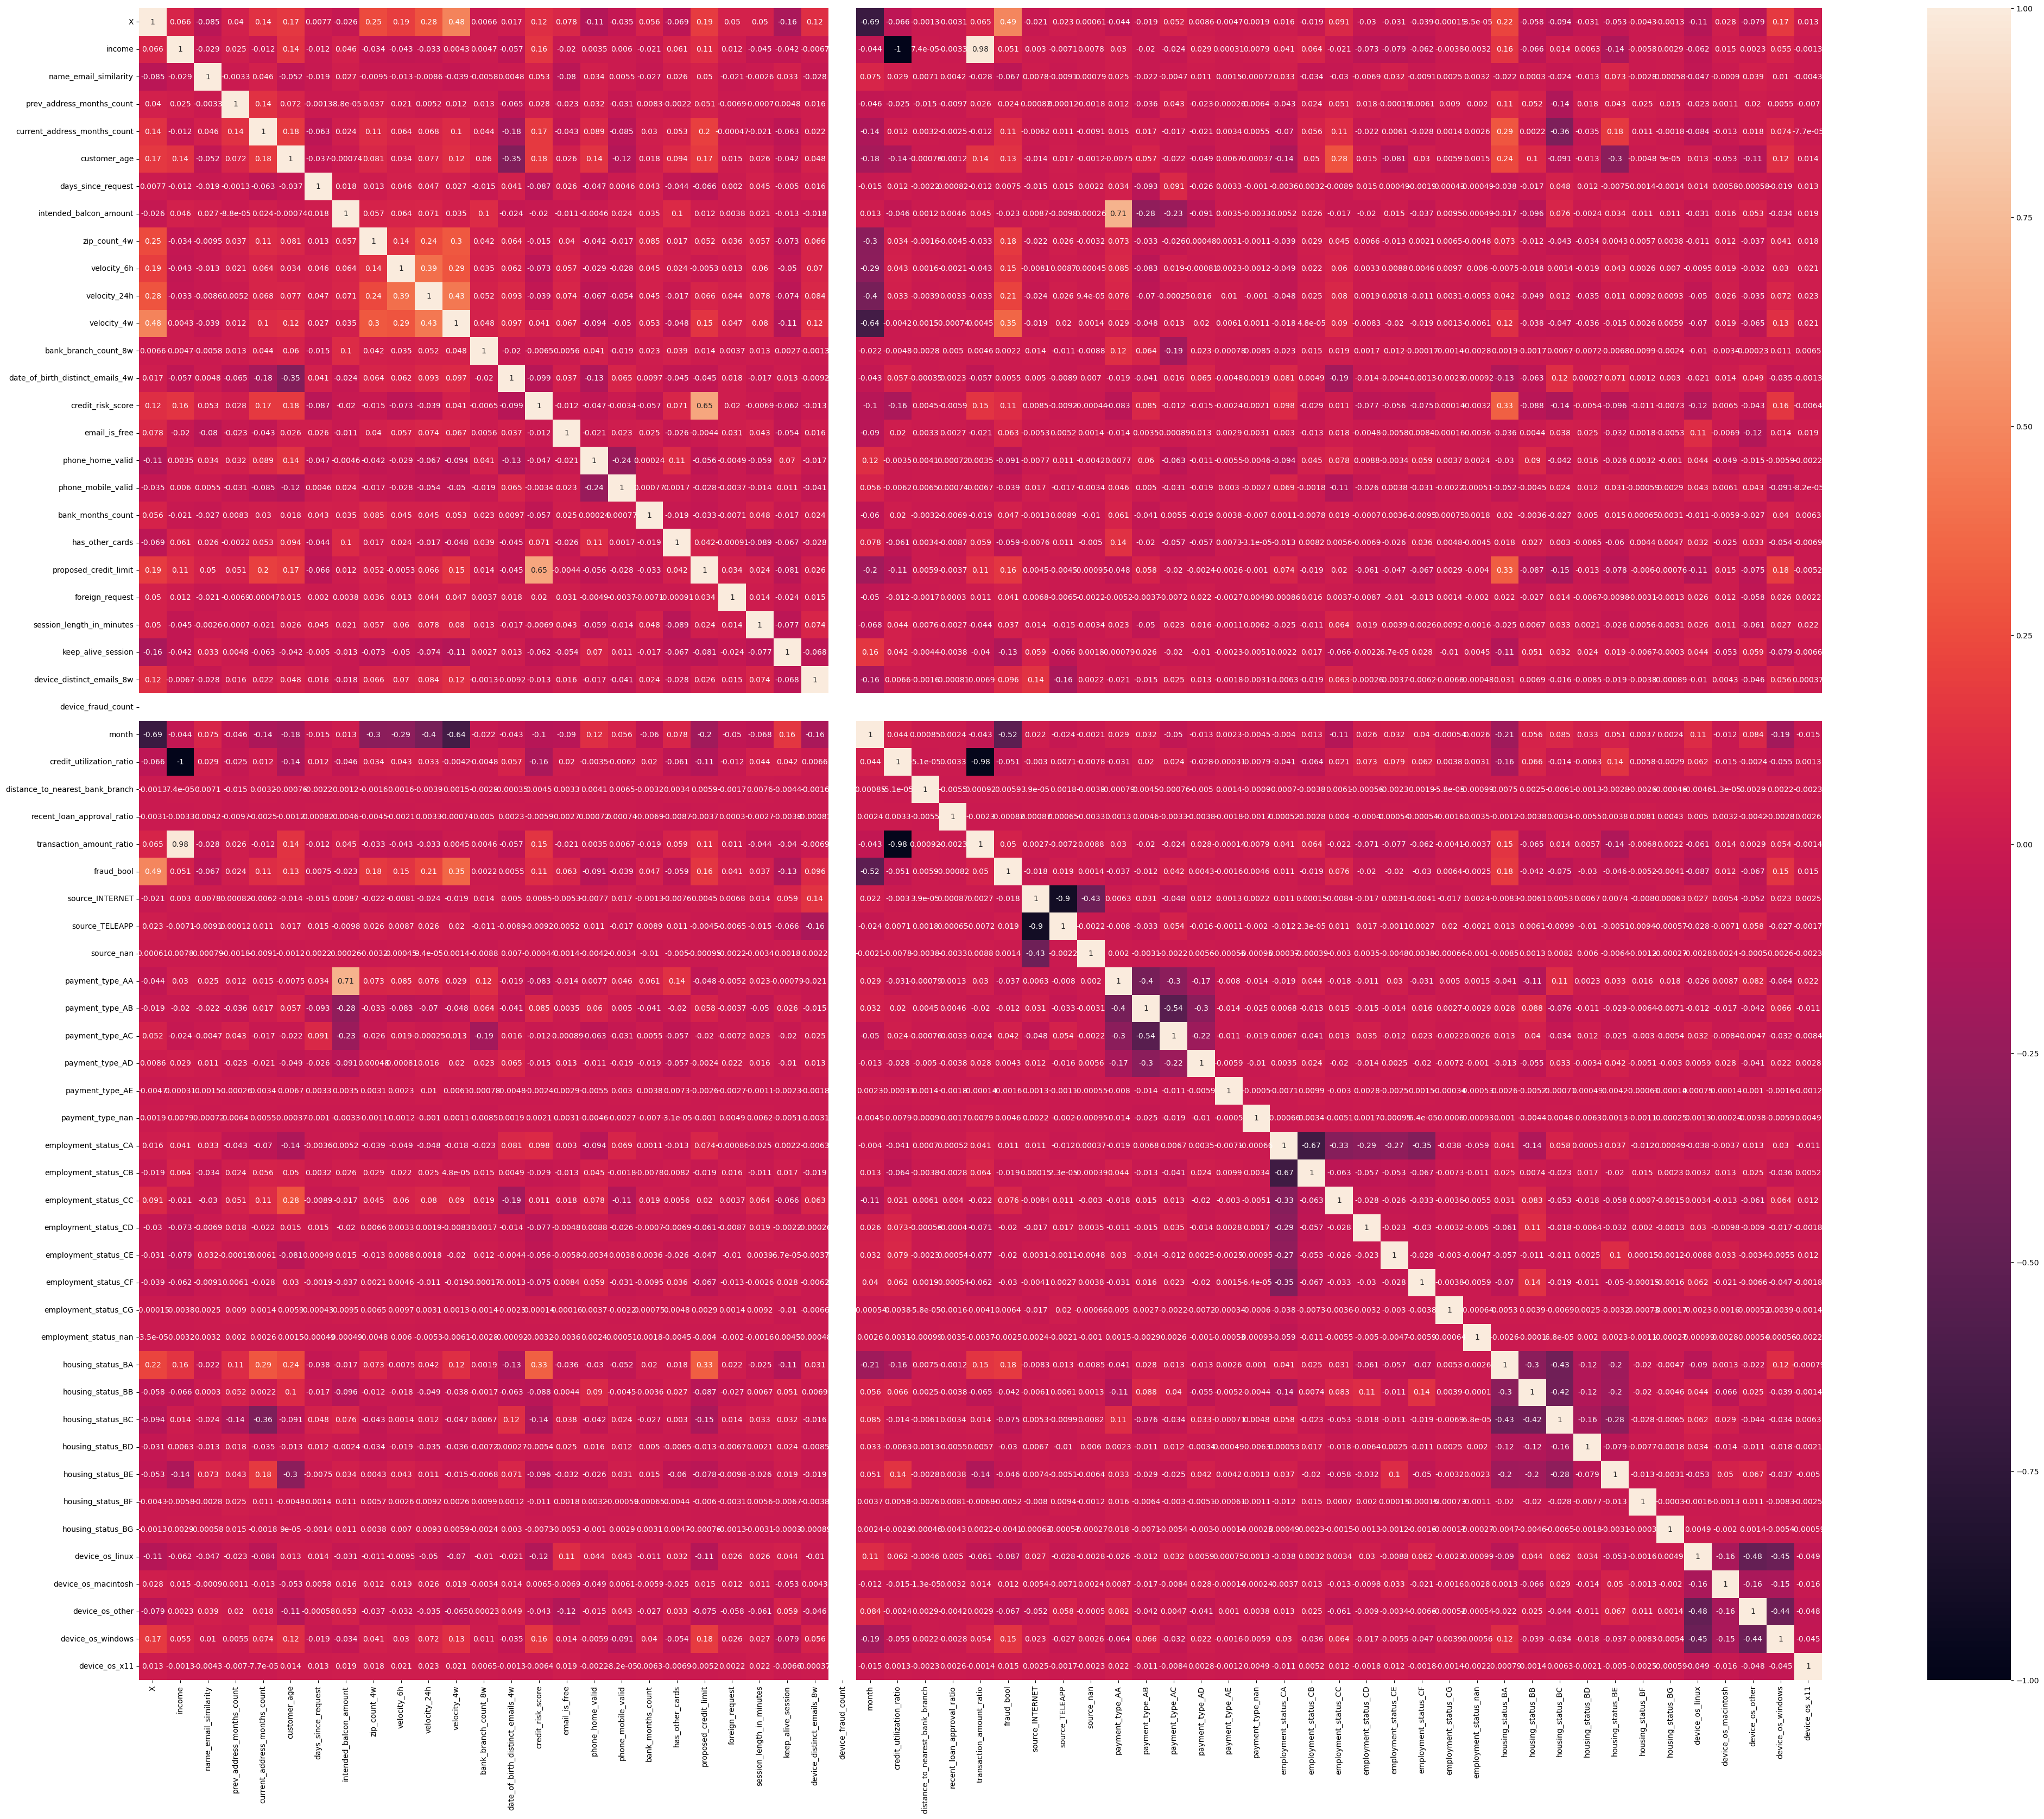

In [286]:
fig, ax = plt.subplots(figsize=(50,40))
sns.heatmap(df.corr(), annot = True, ax=ax)
plt.savefig('correlation_heatmap.png')

In [287]:
def plot_histograms(dataframe):
    numerical_columns = dataframe.select_dtypes(include=np.number).columns
    for column in numerical_columns:
        plt.figure(figsize=(8, 6))
        dataframe[column].hist(bins=20, color='blue', edgecolor='black')
        plt.title(f'Histogram for {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
#plot_histograms(df)

In [ ]:
def plot_histograms(dataframe):
    numerical_columns = dataframe.select_dtypes(include=np.number).columns
    
    fraud_color = 'red'
    non_fraud_color = 'blue'
    
    for column in numerical_columns:
        plt.figure(figsize=(8, 6))
        
        fraud_data = dataframe[dataframe['fraud_bool'] == 1][column]
        non_fraud_data = dataframe[dataframe['fraud_bool'] == 0][column]
        
        # Plot histograms with different colors
        plt.hist(non_fraud_data, bins=20, color=non_fraud_color, edgecolor='black', alpha=0.7, label='Non-Fraud')
        plt.hist(fraud_data, bins=20, color=fraud_color, edgecolor='black', alpha=0.7, label='Fraud')
        plt.title(f'Histogram for {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.legend(loc='upper right')
        plt.show()
plot_histograms(df)

In [288]:
def plot_cm(cm):
    class_labels = ['No_Fraud', 'Fraud']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix:')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()

In [289]:
def performance_metrics(y_train, predictions):
    print('Precision Score:', round(precision_score(y_train, predictions) * 100, 2), '%')
    print('Recall Score:', round(recall_score(y_train, predictions) * 100, 2), '%')
    print('Accuracy Score:', round(accuracy_score(y_train, predictions) * 100, 2), '%')
    print('F1 Score:', round(f1_score(y_train, predictions) * 100, 2), '%')

In [290]:
#train data
df = df.drop(axis=1, labels='device_fraud_count')
df = df.drop("prev_address_months_count", axis=1, errors="ignore")
df = df.drop("transaction_amount_ratio", axis=1, errors="ignore")
df = df.drop("credit_utilization_ratio", axis=1, errors="ignore")
df = df.drop("X", axis=1, errors="ignore")
df.reset_index(inplace=True, drop=True)

#test data
df_test = df_test.drop(axis=1, labels='device_fraud_count')
df_test = df_test.drop("prev_address_months_count", axis=1, errors="ignore")
df_test = df_test.drop("transaction_amount_ratio", axis=1, errors="ignore")
df_test = df_test.drop("credit_utilization_ratio", axis=1, errors="ignore")
df_test = df_test.drop("X", axis=1, errors="ignore")
df_test.reset_index(inplace=True, drop=True)


In [291]:

df = df.dropna(thresh=len(df.columns) * 0.7, axis=1) # Drop any column with more than 70% missing values
df = df.dropna(thresh=len(df.columns) * 0.5) # Drop any row with more than 50% missing values
df.fillna(df.mode().iloc[0], inplace=True) # Fill any missing values with the mode for the column


# test data
df_test = df_test.dropna(thresh=len(df_test.columns) * 0.7, axis=1) # Drop any column with more than 70% missing values
df_test = df_test.dropna(thresh=len(df_test.columns) * 0.5) # Drop any row with more than 50% missing values
df_test.fillna(df_test.mode().iloc[0], inplace=True) # Fill any missing values with the mode for the column

In [292]:
scaler = StandardScaler()
X_train = df.drop(labels='fraud_bool', axis=1)
X_train_scaled = scaler.fit_transform(X_train)
y_train = df.fraud_bool
X_test = df_test.copy()
X_test_scaled = scaler.fit_transform(X_test)

In [293]:
crv = RepeatedStratifiedKFold(n_splits=8, n_repeats=5, random_state=19)
train_folds = []
validation_folds = []
for train_index, test_index in crv.split(X_train, y_train):
    train_folds.append(train_index)
    validation_folds.append(test_index)

In [294]:
scoring_metrics = {
    "Recall": "recall", 
    "BACC": "balanced_accuracy", 
    "F1": "f1", 
    "ROC-AUC": "roc_auc"
}

In [295]:
def descision_tree():
        params = {
                "ccp_alpha": [0.001], # [0.1, 0.01 , 0.001]
                'max_depth': [50], # [10, 20, 30, 40, 50]
                'min_samples_split': [2], # [2, 5, 10]
                'min_samples_leaf': [1], # [1, 2, 5, 10]
                'max_features': ['sqrt'], # ['sqrt', 'log2']
                'class_weight': [{0: 1, 1: 4}], # [{0: 1, 1: 4}]
                'criterion': ['entropy'] # ['gini', 'entropy']
        }
        
        dtc = DecisionTreeClassifier(random_state=19)
        grid1 = GridSearchCV(dtc, params, cv=zip(train_folds,validation_folds), scoring=scoring_metrics, refit="ROC-AUC", return_train_score=True, n_jobs=-1, verbose=True)
        grid1.fit(X_train_scaled, y_train)
        predictions = grid1.predict(X_train_scaled)
        cfmtx = confusion_matrix(y_train, predictions)
        plot_cm(cfmtx)
        performance_metrics(y_train, predictions)
        print('Train roc-auc: {}'.format(roc_auc_score(y_train, predictions)))
        print("Best Parameters:", grid1.best_params_)
        print("Best Score:", grid1.best_score_)
        save('dt', grid1.predict_proba(X_test_scaled)[:, 1])
        return grid1

In [296]:
def random_forest():
    params = {
        'n_estimators': [150], # [150]
        'max_depth': [10], # [10, 20, 30, 40]
        'min_samples_split': [5], # [2, 5]
        'min_samples_leaf': [2], # [1, 2]
        'max_features': ['sqrt'], # ['sqrt', 'log2']
        'class_weight': [{0: 1, 1: 5}], # [{0: 1, 1: 4}]
        'criterion': ['entropy'] # ['gini', 'entropy']
    }

    rfc = RandomForestClassifier(verbose=True, random_state=19)

    grid2 = GridSearchCV(rfc, params, cv=zip(train_folds,validation_folds), scoring=scoring_metrics, refit="ROC-AUC", return_train_score=True, n_jobs=-1, verbose=True)
    grid2.fit(X_train_scaled, y_train)
    predictions2 = grid2.predict(X_train_scaled)
    cfmtx = confusion_matrix(y_train, predictions2)
    plot_cm(cfmtx)
    performance_metrics(y_train, predictions2)
    print('Train roc-auc: {}'.format(roc_auc_score(y_train, predictions2)))
    print("Best Parameters:", grid2.best_params_)
    print("Best Score:", grid2.best_score_)
    save('rf', grid2.predict_proba(X_test_scaled)[:, 1])
    return grid2
#random_forest()

In [297]:
def xgboost():
    params = {
        "max_depth": [3], # [1, 2, 3, 4, 5]
        "eta": [0.05], # [0.04, 0.05, 0.06]
        "gamma": [0], # [0, 0.005, 0.01, 0.1]
        "lambda": [6], # [4, 5, 6, 7]
        "scale_pos_weight": [4], # [0, 1, 2, 4]
        "min_child_weight": [0.6], # [0.5, 0.6, 0.7]
        "n_estimators": [100] # [50, 100, 150, 200]
    }

    base = {'objective': 'reg:logistic', 'nthread': -1, 'eval_metric': 'auc'}

    xgb = XGBClassifier(**base, seed=19)
    grid3 = GridSearchCV(xgb, params, cv=zip(train_folds,validation_folds), scoring=scoring_metrics, refit="ROC-AUC", return_train_score=True, n_jobs=-1, verbose=True)
    grid3.fit(X_train_scaled, y_train)
    predictions3 = grid3.predict(X_train_scaled)
    cfmtx = confusion_matrix(y_train, predictions3)
    plot_cm(cfmtx)
    performance_metrics(y_train, predictions3)
    print('Train roc-auc: {}'.format(roc_auc_score(y_train, predictions3)))
    print("Best Parameters:", grid3.best_params_)
    print("Best Score:", grid3.best_score_)
    save('xgb', grid3.predict_proba(X_test_scaled)[:, 1])
    return grid3
#xgboost()

In [298]:
def LogRegression():
    params = {
        "solver": ['newton-cholesky'], # ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        "penalty": ['l2'], # ['l2', 'none']
        'class_weight': [{0: 1, 1: 4}], # [{0: 1, 1: 4}]
        'C': [1000] # [0.001, 0.01, 1, 100, 1000]
    }

    lr = LR(verbose=True, n_jobs=-1, random_state=19)
    grid4 = GridSearchCV(lr, params, cv=zip(train_folds,validation_folds), scoring=scoring_metrics, refit="ROC-AUC", return_train_score=True, n_jobs=-1, verbose=True)  
    grid4.fit(X_train_scaled, y_train)
    predictions4 = grid4.predict(X_train_scaled)
    cfmtx = confusion_matrix(y_train, predictions4)
    plot_cm(cfmtx)
    performance_metrics(y_train, predictions4)
    print('Train roc-auc: {}'.format(roc_auc_score(y_train, predictions4)))
    print("Best Parameters:", grid4.best_params_)
    print("Best Score:", grid4.best_score_)
    save('logreg', grid4.predict_proba(X_test_scaled)[:, 1])
    return grid4
#LogRegression()

Fitting 40 folds for each of 1 candidates, totalling 40 fits


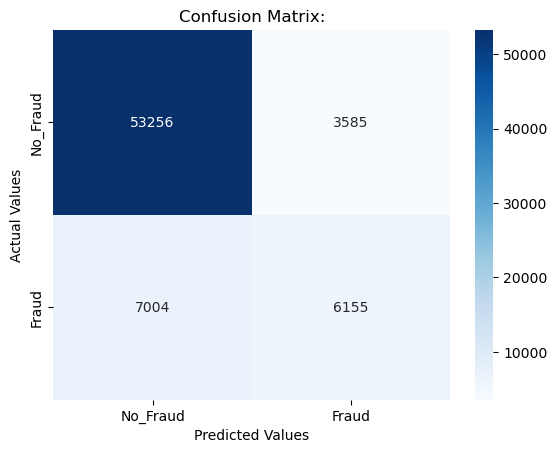

Precision Score: 63.19 %
Recall Score: 46.77 %
Accuracy Score: 84.87 %
F1 Score: 53.76 %
Train roc-auc: 0.7023350194808896
Best Parameters: {'ccp_alpha': 0.001, 'class_weight': {0: 1, 1: 4}, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.7205575091939356
[2024-01-03 15:22:57.907983] Saving at ./dt11.csv


GridSearchCV(cv=<zip object at 0x00000210AD496900>,
             estimator=DecisionTreeClassifier(random_state=19), n_jobs=-1,
             param_grid={'ccp_alpha': [0.001], 'class_weight': [{0: 1, 1: 4}],
                         'criterion': ['entropy'], 'max_depth': [50],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2]},
             refit='ROC-AUC', return_train_score=True,
             scoring={'BACC': 'balanced_accuracy', 'F1': 'f1',
                      'ROC-AUC': 'roc_auc', 'Recall': 'recall'},
             verbose=True)

In [300]:
#descision_tree() # 0.7205575091939356

Fitting 40 folds for each of 1 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   41.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.9s finished


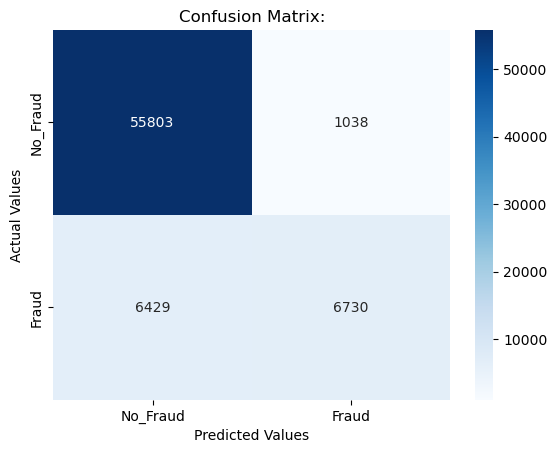

Precision Score: 86.64 %
Recall Score: 51.14 %
Accuracy Score: 89.33 %
F1 Score: 64.32 %
Train roc-auc: 0.746587786546762
Best Parameters: {'class_weight': {0: 1, 1: 5}, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.744636182932744


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[2024-01-03 15:26:42.321802] Saving at ./rf6.csv


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished


GridSearchCV(cv=<zip object at 0x00000210C0A38580>,
             estimator=RandomForestClassifier(random_state=19, verbose=True),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 5}],
                         'criterion': ['entropy'], 'max_depth': [10],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2],
                         'min_samples_split': [5], 'n_estimators': [150]},
             refit='ROC-AUC', return_train_score=True,
             scoring={'BACC': 'balanced_accuracy', 'F1': 'f1',
                      'ROC-AUC': 'roc_auc', 'Recall': 'recall'},
             verbose=True)

In [301]:
#random_forest() # 0.7444827176463975

Fitting 40 folds for each of 1 candidates, totalling 40 fits


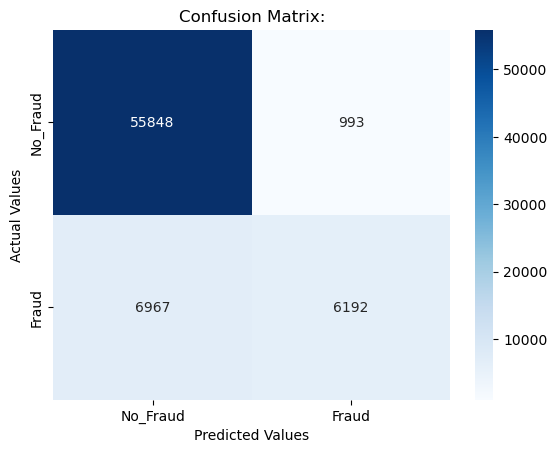

Precision Score: 86.18 %
Recall Score: 47.06 %
Accuracy Score: 88.63 %
F1 Score: 60.87 %
Train roc-auc: 0.7265413447287634
Best Parameters: {'eta': 0.05, 'gamma': 0, 'lambda': 6, 'max_depth': 3, 'min_child_weight': 0.6, 'n_estimators': 100, 'scale_pos_weight': 4}
Best Score: 0.7477731016819724
[2024-01-03 15:26:51.500085] Saving at ./xgb1.csv


GridSearchCV(cv=<zip object at 0x00000210AA19F800>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_const...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.05], 'gamma': [0], 'lambda': [6],
                         'max_depth': [3], 'min_child_weight': [0.6],
                         'n_estimators': [100], 'scale_pos_weight': [4]},
             refit='ROC-AUC', return_train_score=True,
             scoring={'BACC': 'balanced_accuracy', 'F1': 'f1',
                      'ROC-AUC': 'roc_auc', 'Recall': 'recall'},
             verbose=True)

In [302]:
xgboost() # 0.7477731016819724

Fitting 40 folds for each of 1 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


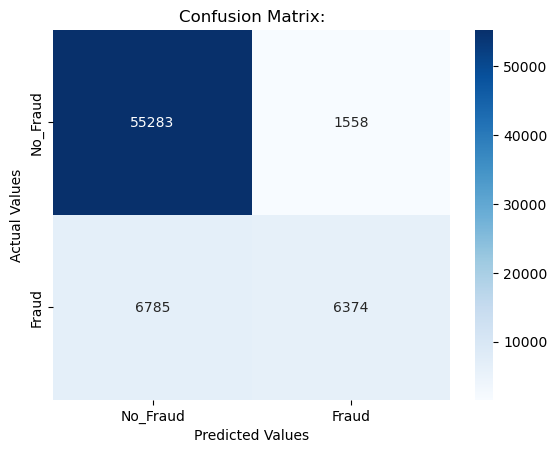

Precision Score: 80.36 %
Recall Score: 48.44 %
Accuracy Score: 88.08 %
F1 Score: 60.44 %
Train roc-auc: 0.7284867597871836
Best Parameters: {'C': 1000, 'class_weight': {0: 1, 1: 4}, 'penalty': 'l2', 'solver': 'newton-cholesky'}
Best Score: 0.7468842399082914
[2024-01-03 15:26:56.296136] Saving at ./logreg2.csv


GridSearchCV(cv=<zip object at 0x00000210A81C20C0>,
             estimator=LogisticRegression(n_jobs=-1, random_state=19,
                                          verbose=True),
             n_jobs=-1,
             param_grid={'C': [1000], 'class_weight': [{0: 1, 1: 4}],
                         'penalty': ['l2'], 'solver': ['newton-cholesky']},
             refit='ROC-AUC', return_train_score=True,
             scoring={'BACC': 'balanced_accuracy', 'F1': 'f1',
                      'ROC-AUC': 'roc_auc', 'Recall': 'recall'},
             verbose=True)

In [303]:
#LogRegression() # 0.7468842399082914